In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-8-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 24.2 s, sys: 389 ms, total: 24.6 s
Wall time: 25.4 s


In [10]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 10s, sys: 1.48 s, total: 4min 11s
Wall time: 4min 16s


А теперь в 3 строчки обучим нашу модель

In [11]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [12]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [13]:
common_dictionary[5]

'банк'

In [14]:
common_corpus[0][0]

(0, 5)

In [15]:
len(texts[1])

40

In [16]:
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

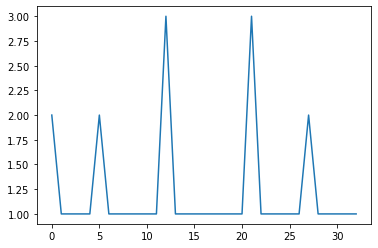

In [17]:
plt.plot(csr_matrix(common_corpus[1]).todense()[:,1])
plt.show()

Все просто - это словарь наших слов

Запускаем обучение

In [18]:
%%time
from gensim.models import LdaModel
num_topics = 25
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=num_topics, id2word=common_dictionary)#, passes=10)

CPU times: user 49.1 s, sys: 2.87 s, total: 52 s
Wall time: 34.7 s


Сохраним модель на диск

In [19]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [20]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(10, 0.047255203),
 (11, 0.03548448),
 (12, 0.05476228),
 (15, 0.45408434),
 (23, 0.38722512)]

In [21]:
x=lda.show_topics(num_topics=num_topics, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print(f"topic_{topic}: {' '.join(words)}")

topic_0: министерство дональд км виза климат озеро сократиться
topic_1: млн исследование тыс млрд составить показатель вырасти
topic_2: пенсия журнал производитель одежда подсчитать nn таиланд
topic_3: военный россия американский сша российский наука новый
topic_4: бизнесмен край область память губернатор потребность мэр
topic_5: гражданин ребёнок млрд украина убийство сотрудник украинский
topic_6: фонд проект запуск nn конкурс форум научный
topic_7: статья район nn взрыв произойти пострадать место
topic_8: космос партнёрство снежный израильский израиль оплатить казак
topic_9: врач умереть превысить мальчик лекарство боль способность
topic_10: эксперт обнаружить всё цена газета банк данные
topic_11: путин владимир дмитрий медведев россия глава энергия
topic_12: nn россия станция москва северный первый проверка
topic_13: определение рекорд кг остаток золото вес су
topic_14: украина банк территория российский участок торговый киев
topic_15: товар nnn nn всё больной космонавт первый
topic

Очень неплохо - большинство тем вполне можно описать о чем они


построим темы 

In [22]:
lda[common_dictionary.doc2bow(news['title'].iloc[5])]

[(10, 0.028910093),
 (11, 0.027696349),
 (13, 0.03950343),
 (14, 0.24787192),
 (15, 0.6418723)]

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [23]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(num_topics):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [24]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(num_topics)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(num_topics)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.087171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,4896,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.327862,0.0,...,0.647917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,4897,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.454033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.387383,0.000000
3,4898,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.618185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033309,0.279042
4,4899,0.0,0.0,0.0,0.0,0.125777,0.0,0.220049,0.000000,0.0,...,0.285466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [25]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [26]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(num_topics)]].values))

In [27]:
doc_dict[11]

array([0.        , 0.07353607, 0.        , 0.09746879, 0.        ,
       0.        , 0.07855313, 0.        , 0.        , 0.        ,
       0.1014067 , 0.        , 0.10822354, 0.        , 0.        ,
       0.05093866, 0.18658207, 0.        , 0.        , 0.        ,
       0.        , 0.22595663, 0.        , 0.07269083, 0.        ])

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

logreg = LogisticRegression()

In [29]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Функция получения заинтересованности пользователем в теме(ах)
Реализована возможность включения или отключения весов tfidf по частоте читаемых документов пользователями

In [31]:
user_articles_list = users['articles'].iloc[512]

def get_user_embedding(user_articles_list, agg_method, tfidf_=False):
    user_articles_list = eval(user_articles_list)
    if tfidf_:
        user_vector = np.array([doc_dict[doc_id] * (tfidf_.idf_[tfidf_.vocabulary_[f'{doc_id}']] if f'{doc_id}' in tfidf_.vocabulary_ else 1)
                                for doc_id in user_articles_list])
    else:
        user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
        
        
    user_vector = agg_method(user_vector, 0)

    return user_vector

get_user_embedding(user_articles_list, agg_method=np.mean)

array([0.03047024, 0.        , 0.00543622, 0.12834991, 0.00319756,
       0.04080352, 0.0640572 , 0.00971497, 0.        , 0.00415836,
       0.15156655, 0.03518277, 0.04616663, 0.00554638, 0.00881952,
       0.00406026, 0.17752429, 0.        , 0.        , 0.        ,
       0.02588027, 0.07632529, 0.0309788 , 0.05833416, 0.08212518])

In [32]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [33]:
metrics_report = list()



 -------------------------
Модель с агрегацией: mean


Best Threshold=0.247311, F-Score=0.638, Precision=0.556, Recall=0.748

Confusion matrix, without normalization
[[1626  140]
 [  60  174]]


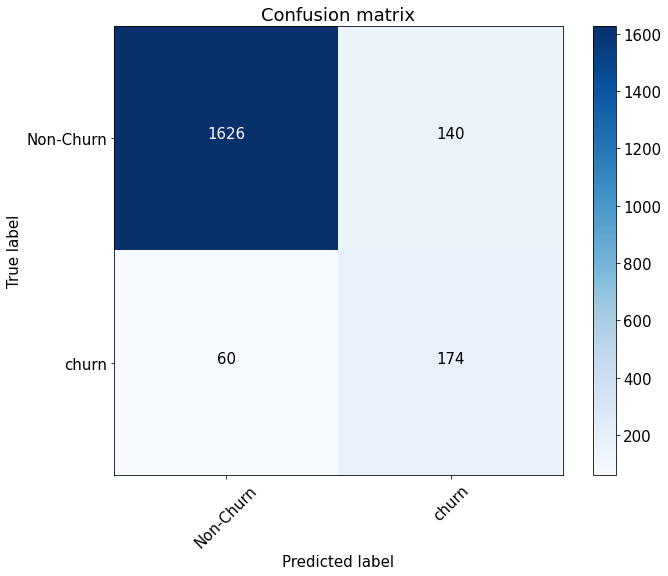

roc_auc_score = 0.9329621240719768


 -------------------------
Модель с агрегацией: median


Best Threshold=0.304995, F-Score=0.695, Precision=0.671, Recall=0.722

Confusion matrix, without normalization
[[1683   83]
 [  66  168]]


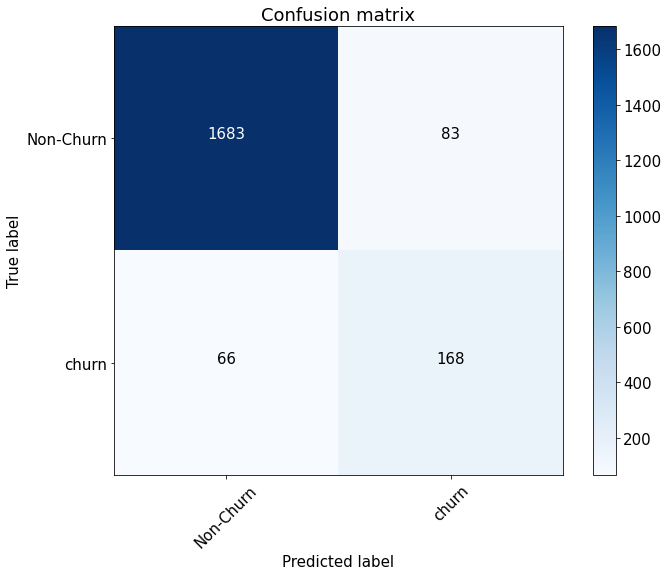

roc_auc_score = 0.9580223790303066


 -------------------------
Модель с агрегацией: sum


Best Threshold=0.317414, F-Score=0.670, Precision=0.597, Recall=0.765

Confusion matrix, without normalization
[[1645  121]
 [  56  178]]


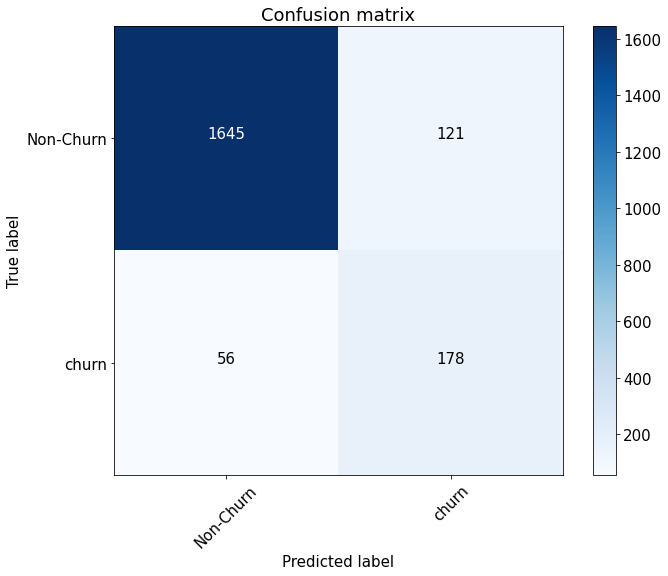

roc_auc_score = 0.9530350107926552


In [34]:
for type_of_aggr in [np.mean, 
                     np.median, 
                     np.sum]:
    
    print("\n\n", "-"*25)
    model_name = f'agg by {type_of_aggr.__name__}'
    print(f'Модель с агрегацией: {type_of_aggr.__name__}\n')

    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, type_of_aggr), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(num_topics)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(num_topics)]]
    user_embeddings.head()

    X = pd.merge(user_embeddings, target, 'left')

    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(num_topics)]], 
                                                        X['churn'], random_state=12)


    #обучим наш пайплайн
    logreg.fit(X_train, y_train)

    #наши прогнозы для тестовой выборки
    preds = logreg.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('\nBest Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f\n' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    #мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()

    roc_auc = roc_auc_score(y_test, preds)
    print(f'roc_auc_score = {roc_auc}')

    metrics_report.append([model_name, roc_auc, fscore[ix], precision[ix], recall[ix]])

# TfidfVectorizer

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
tfidf = TfidfVectorizer()

In [36]:
tfidf.fit_transform(users['articles'])

<8000x14781 sparse matrix of type '<class 'numpy.float64'>'
	with 47957 stored elements in Compressed Sparse Row format>



 -------------------------
Модель с агрегацией mean с весами tfidf


Best Threshold=0.440176, F-Score=0.824, Precision=0.837, Recall=0.812

Confusion matrix, without normalization
[[1729   37]
 [  45  189]]


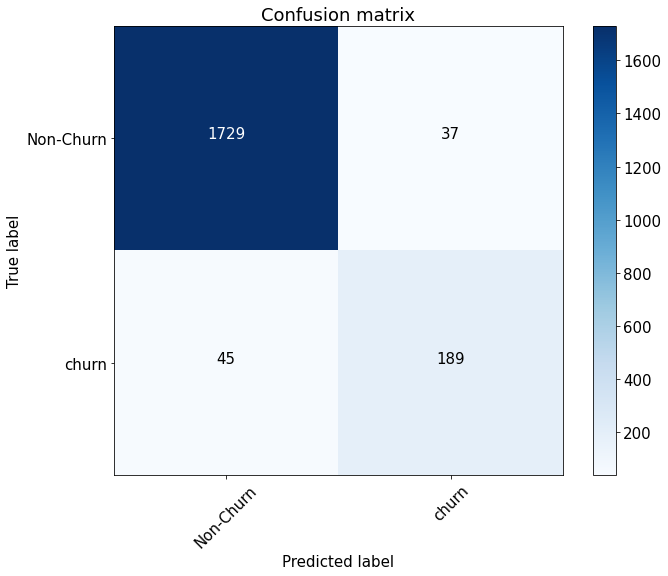

roc_auc_score = 0.9833609199407614


In [37]:
type_of_aggr = np.mean

print("\n\n", "-"*25)

model_name = f'agg by {type_of_aggr.__name__} with tfidf wights'

print(f'Модель с агрегацией {type_of_aggr.__name__} с весами tfidf\n')

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, type_of_aggr, tfidf), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(num_topics)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(num_topics)]]
user_embeddings.head()

X = pd.merge(user_embeddings, target, 'left')

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(num_topics)]], 
                                                    X['churn'], random_state=12)


#обучим наш пайплайн
logreg.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('\nBest Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f\n' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

roc_auc = roc_auc_score(y_test, preds)
print(f'roc_auc_score = {roc_auc}')

metrics_report.append([model_name, roc_auc, fscore[ix], precision[ix], recall[ix]])

In [38]:
pd.DataFrame(metrics_report, columns=['model_name', 'roc_auc', 'F-score', 'precision', 'recall'])

,model_name,roc_auc,F-score,precision,recall
0,agg by mean,0.932962,0.637523,0.555556,0.747863
1,agg by median,0.958022,0.695473,0.670635,0.722222
2,agg by sum,0.953035,0.670412,0.596667,0.764957
3,agg by mean with tfidf wights,0.983361,0.824295,0.837004,0.811966


### Последняя модель с весами (tfidf) по частоте документов просматриваемых пользователями отработала лучше, так как более значимые для классификации оттока документы получили большие веса, а следовательно внесли больший вклад в модель.